# Modelling Selected Parameters at 0:00 + Day Phase

## KNeighborsRegressor - Hyperparameter Tuning

In [1]:
# Importing the libraries
import os
import pandas as pd

In [2]:
# Load and preprocess the train data 
from pipelines import pipeline

data_file = os.path.join('..', '..', '..', '..', 'data', 'raw', 'train.csv')
train_data = pd.read_csv(data_file, index_col=0, low_memory=False)
train_data = pipeline.fit_transform(train_data)
train_data.head()

,bg-2:00,bg-1:55,bg-1:50,bg-1:45,bg-1:40,bg-1:35,bg-1:30,bg-1:25,bg-1:20,bg-1:15,...,bg-0:20,bg-0:15,bg-0:10,bg-0:05,bg-0:00,bg+1:00,day_phase_evening,day_phase_morning,day_phase_night,day_phase_noon
id,,,,,,,,,,,,,,,,,,,,,
p01_0,2.979792,3.094627,3.205219,3.313738,3.339790,3.360325,3.378547,3.337554,3.291901,3.243637,...,2.767561,2.641773,2.523390,2.400975,2.275154,13.4,False,True,False,False
p01_1,3.313825,3.339864,3.361240,3.380543,3.339790,3.293475,3.245003,3.170443,3.091433,3.010016,...,2.400222,2.274907,2.200512,2.122636,2.041687,12.8,False,True,False,False
p01_2,3.380632,3.339864,3.294374,3.246934,3.172584,3.092925,3.011302,3.036755,3.058022,3.076765,...,2.121935,2.041447,1.988971,1.933365,1.874925,15.5,False,True,False,False
p01_3,3.247019,3.172657,3.093776,3.013119,3.038818,3.059500,3.078074,3.059036,3.035748,3.010016,...,1.932700,1.874690,1.866500,1.855430,1.841572,14.8,False,True,False,False
p01_4,3.013196,3.038892,3.060343,3.079923,3.061113,3.037216,3.011302,2.891926,2.768457,2.642898,...,1.854780,1.841338,1.799698,1.755228,1.708162,12.7,False,True,False,False


In [3]:
X = train_data.drop(columns=['bg+1:00'])
y = train_data['bg+1:00']

In [4]:
import numpy as np
from skopt import BayesSearchCV
from sklearn.neighbors import KNeighborsRegressor
from skopt.space import Integer, Categorical

param_space = {
    'n_neighbors': Integer(3, 11),
    'weights': Categorical(['uniform', 'distance']),
    'algorithm': Categorical(['auto', 'ball_tree', 'kd_tree', 'brute']), 
    'leaf_size': Integer(20, 50),  # Continuous range for integer leaf_size
    'p': Categorical([1, 2]) # L1 or L2 distance
}

k_neighbors_regressor = KNeighborsRegressor()
bayes_search = BayesSearchCV(
    estimator=k_neighbors_regressor,
    search_spaces=param_space,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    random_state=42
)

# Fit the model
np.int = int
bayes_search.fit(X=X, y=y)

# Get the best parameters and best score
best_params = bayes_search.best_params_
best_score = bayes_search.best_score_

print("Best parameters found: ", best_params)
print("Best score: ", best_score)

/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been 

Best parameters found:  OrderedDict({'algorithm': 'kd_tree', 'leaf_size': 20, 'n_neighbors': 11, 'p': 2, 'weights': 'uniform'})
Best score:  -5.255923019344582


In [5]:
# create and save model with best parameters
import joblib

k_neighbors_regressor = KNeighborsRegressor(**best_params)
joblib.dump(k_neighbors_regressor, 'knr.model.pkl')

['knr.model.pkl']

RMSE: 1.721826380608968
R2: 0.6697961962477332


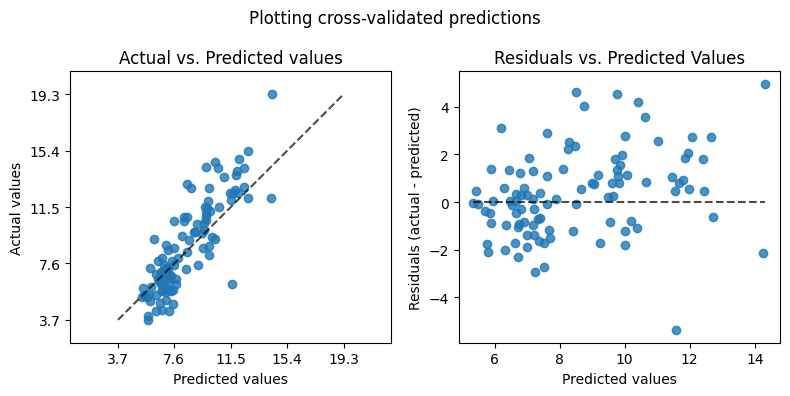

In [6]:
from sklearn.metrics import root_mean_squared_error, r2_score, PredictionErrorDisplay
import matplotlib.pyplot as plt

k_neighbors_regressor.fit(X=X, y=y)
y_pred = k_neighbors_regressor.predict(X=X)
print(f'RMSE: {root_mean_squared_error(y_true=y, y_pred=y_pred)}')
print(f'R2: {r2_score(y_true=y, y_pred=y_pred)}')

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_true=y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y_true=y,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show();